# Solving Wasserstein Gradient Flow using Sinkhorn's Algorithm
Throughout the notebook, let us adapt the following setting. For $n \in \mathbb{N}$, define $\Omega \subseteq \mathbb{R}^n$ be a compact subset of $n$ dimensional Euclidean space, and $\mathcal{P}(\Omega)$ be a space of Borel probability measures on $\Omega$. The 2-Wasserstein space is defined as a metric space of probability measures endowed with what so called a 2-Wasserstein metric $W_2: \mathcal{P}(\Omega) \times \mathcal{P}(\Omega) \to [0,\infty]$, defined as, $$W_2(\mu,\nu) = \left( \inf_{\gamma \in \Pi(\mu,\nu)} \int_{\Omega^2} \vert x-y\vert^2 d\gamma(x,y) \right)^{1/2}$$ where $\Pi(\mu,\nu) \coloneqq \{\gamma \in \mathcal{P}(\Omega^2) : \pi_{1}\sharp\gamma = \mu, \pi_{2}\sharp\gamma = \nu\}$.

In [1]:
from src.jko_lab import *
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
from jax import lax
import optax
from __future__ import annotations
from typing import Callable, Optional, Tuple, List
import flax.struct as flstr
Array = jnp.ndarray

## Wasserstein gradient flow
Given a functional $\mathcal{F} : \mathcal{P}_2(\Omega) \to \mathbb{R}$, a curve $(\rho_t)_{t\geq 0}$ in $\mathcal{P}_2(\Omega)$ is called a \emph{Wasserstein gradient flow} of $\mathcal{F}$ if $$\frac{d\rho_t}{dt} = - \nabla_{W_2}F(\rho_t),$$ meaning that $\rho_t$ evolves in the direction of steepest descent of $\mathcal{F}$ with respect to the $W_2$ metric. If $\rho_t$ admits a Radon-Nikodym derivative, i.e. density, this Wasserstein gradient flow corresponds to the PDE $$\partial_t \rho_t = \nabla \cdot \left( \rho_t \nabla \frac{\delta \mathcal{F}}{\delta \rho} (\rho_t) \right).$$

#### Visualization Tools
Following cells contain codes for visualizing the flow, sinkhorn's algorithm iterations, and etc.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_hist_flow(
    mu_list,
    x,
    target=None,                 # optional target mass/density: same length as x
    interval=200,                # ms between frames
    title="Gradient Flow",
    xlabel="x",
    ylabel="Probability Density",
    bar_alpha=0.5,
    bar_edge="black",
    bar_color=None,              # None -> Matplotlib default
    line_color="red",
    ylim_pad=1.1,                # y-axis headroom factor
    return_html=True,            # return HTML string for display in notebooks
):
    """
    Animate a sequence of 1D measures as a bar 'histogram' over a fixed grid.

    Args
    ----
    mu_list : array-like, shape (T, n) or list of (n,)
        Sequence of measures (bin masses). Each frame will be normalized to sum=1.
    x : array-like, shape (n,)
        Bin centers (uniformly spaced).
    target : array-like, shape (n,), optional
        Target distribution. If supplied, it's plotted as a line (interpreted as mass; converted to density).
    interval : int
        Milliseconds between frames.
    title, xlabel, ylabel : str
        Labels.
    bar_alpha, bar_edge, bar_color : visual args for bars.
    line_color : color for the target curve.
    ylim_pad : float
        Multiplier for max y to add headroom.
    return_html : bool
        If True, return HTML string from ani.to_jshtml(); else return the Matplotlib Animation object.

    Returns
    -------
    HTML string (if return_html=True) or the Animation object.
    """
    # Convert to numpy (handles JAX arrays)
    mu_arr = np.asarray(mu_list)
    x = np.asarray(x)
    T, n = mu_arr.shape

    # Uniform bin width from centers
    if n < 2:
        raise ValueError("x must have at least 2 points to infer bin width.")
    bin_width = float(x[1] - x[0])

    # Densities for initial frame
    y0 = mu_arr[0] / np.sum(mu_arr[0])
    y0_density = y0 / bin_width

    # Optional target (mass or density -> convert to density)
    target_density = None
    if target is not None:
        tgt = np.asarray(target)
        if tgt.shape != (n,):
            raise ValueError("target must have shape (n,), same length as x.")
        # If target sums to ~1, treat as mass; otherwise assume it's already density
        if 0.9 <= float(np.sum(tgt)) <= 1.1:
            target_density = tgt / (np.sum(tgt) * bin_width)
        else:
            target_density = tgt

    # Figure/axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars at bin centers with width=bin_width
    bars = ax.bar(
        x, y0_density, width=bin_width, alpha=bar_alpha,
        align="center", edgecolor=bar_edge, color=bar_color, label="Distribution"
    )

    # Overlay target curve if provided
    if target_density is not None:
        (target_line,) = ax.plot(x, target_density, color=line_color, lw=2, label="Target Distribution")
    else:
        target_line = None

    # Axis limits
    y_max = y0_density.max()
    if target_density is not None:
        y_max = max(y_max, float(np.max(target_density)))
    ax.set_xlim(x.min() - 0.5 * bin_width, x.max() + 0.5 * bin_width)
    ax.set_ylim(0, y_max * ylim_pad)

    # Labels and legend
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title} — step 0 / {T-1}")
    ax.legend()

    # Init function: zero bars (optional eye-candy)
    def init():
        for b in bars:
            b.set_height(0.0)
        return bars

    # Update per frame
    def animate(i):
        yi = mu_arr[i]
        yi = yi / np.sum(yi)            # normalize to probability mass 1
        yi_density = yi / bin_width      # convert to density
        for b, h in zip(bars, yi_density):
            b.set_height(float(h))
        ax.set_title(f"{title} — step {i} / {T-1}")
        return bars

    ani = animation.FuncAnimation(
        fig, animate, frames=np.arange(T), init_func=init,
        interval=interval, blit=True
    )
    plt.close(fig)  # avoid static figure in notebooks

    if return_html:
        return HTML(ani.to_jshtml())
    return ani

COLORS = ["red", "green", "blue", "orange", "purple"]

def plot_vectors(n: int, data: dict):
    """
    Plots vectors supported on [-5,5] with respect to labels.
    """
    x = jnp.linspace(-1, 1, n)
    fig = plt.figure(figsize=(8, 6))
    i = 0
    for label, vec in data.items():
        plt.plot(x, vec, label=rf'\{label}', color=COLORS[i])
        i += 1
    plt.legend()

Add details of the Sinkhorn's algorithm, both in continuous and discrete case.

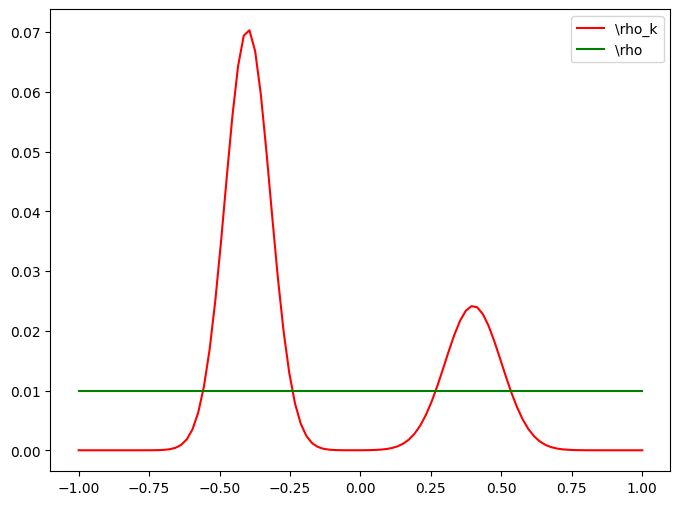

In [3]:
key = jax.random.PRNGKey(42)
n = 100

# 1D grid on [0,1]
x = jnp.linspace(0, 1, n)
C = (x[:,None] - x[None,:])**2 # cost matrix

# Target marginal rho_k (right marginal), a bimodal distribution
rho_k = 0.7 * jax.scipy.stats.norm.pdf(x, 0.3, 0.04) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.7, 0.05)
rho_k = jnp.clip(rho_k, 1e-12, None)
rho_k = rho_k / rho_k.sum()

rho = jnp.ones_like(rho_k)
rho = rho / rho.sum()

plot_vectors(n, {
    "rho_k": rho_k,
    "rho": rho
    })

We solve the entropy-regularized optimal transport problem
$$
\arg\min \langle C, \pi\rangle + \varepsilon H(\pi)
$$
with $\mathrm{rs}(\pi)=\rho^k$, $\mathrm{cs}(\pi)=\rho$ via Sinkhorn algorithm.

In [4]:
eta = 1e-2 # JKO step size
epsilon = 1e-3 # Sinkhorn regularization parameter

# Run solver
solver = Sinkhorn(
    C=C,
    a=rho,
    b=rho_k,
    epsilon=epsilon,
    max_iters=2000,
    tol=1e-9
)

# extract outputs
pi, f, g, error, iters = solver.solve()
# print basic info
print("Column feasibility ||pi^T 1 - rho_k||:", float(jnp.linalg.norm(col_sums(pi) - rho_k)))
print(f"Convergence in {iters} iterations")
print("Mass check (should be 1):", float(rho.sum()))

Column feasibility ||pi^T 1 - rho_k||: 7.963499378107494e-16
Convergence in 2000 iterations
Mass check (should be 1): 1.0000000000000002


The performance of the algorithm is measured by the following.

Text(0.5, 1.02, 'Summary of Sinkhorn Algorithm')

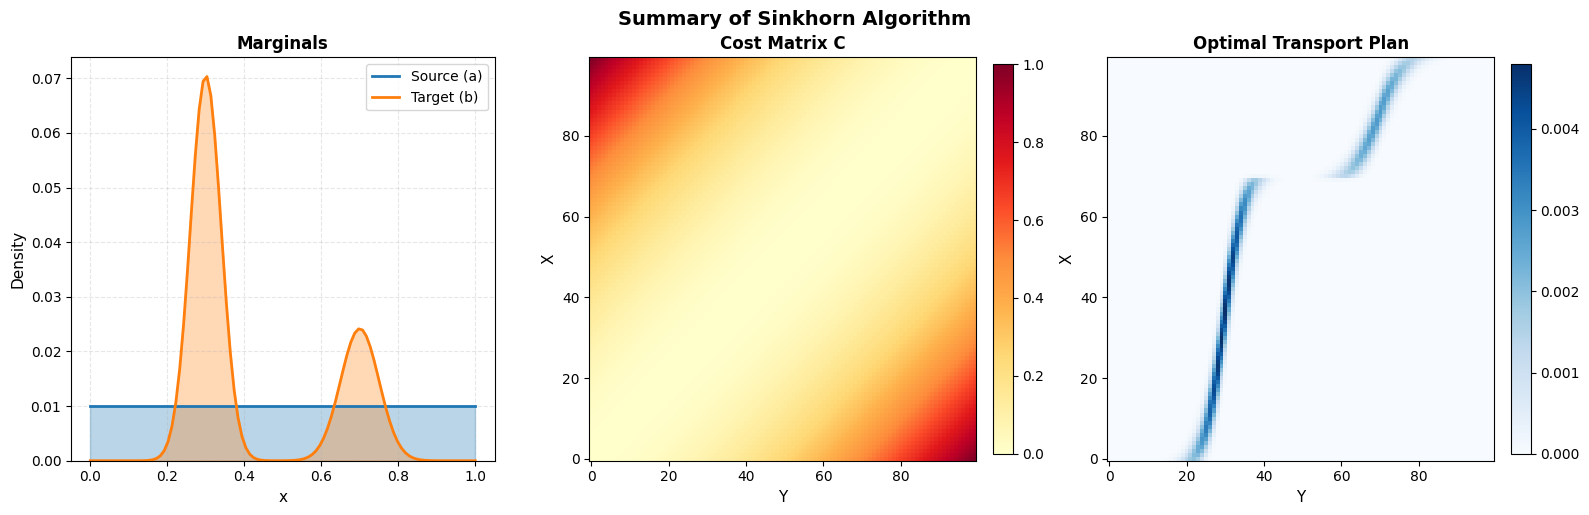

In [5]:
# Create summary
fig = plot_sinkhorn_summary(
    C=C,
    a=rho,
    b=rho_k,
    pi=pi,
    x_source=x,
    x_target=x,
    figsize=(16, 5)
)
plt.suptitle(f'Summary of Sinkhorn Algorithm', fontsize=14, fontweight='bold', y=1.02)

The following wrapper function computes squared entropy-regularized 2-Wasserstein distance using warm-start Sinkhorn's algorithm.
$$
W_{2,\epsilon}^2(\rho,\rho^k) = \underset{\gamma \to \Pi(\rho,\rho^k)}{\inf}\left\{ \int_{X\times X} C(x,y) d\gamma + \epsilon\int_{X\times X} \frac{d\gamma}{d(\rho \otimes \rho^k)} \log\left(\frac{d\gamma}{d(\rho \otimes \rho^k)}\right) - \frac{d\gamma}{d(\rho \otimes \rho^k)} d\gamma \right\}
$$
Here, we provide an extra argument to the Sinkhorn algorithm that is a Kantorovich potentials $u, v \in C(X)$. Starting from these two dual potentials, and current marginal probability distribution $\rho \in \mathcal{P}(X)$, we approximate the 2-Wasserstein distance.

#### Quadratic Flow
Starting from a uniform distribution $b$, and quadratic entropy, we take our original starting marginal $\rho^0 = \frac{3}{4}\mathcal{N}(0.3,0.05)+\frac{1}{4}\mathcal{N}(0.8,0.03)$, run the wasserstein gradient flow.

In [6]:
# Choose F = entropy (negative Boltzmann-Shannon)
def F_value_entropy(rho: jax.Array) -> jax.Array:
    rho_safe = jnp.clip(rho, 1e-12, None) # prevent log(0)
    return jnp.sum(rho_safe * (jnp.log(rho_safe)) - 1.0)

n = 100
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

eta = 1e-3                 
epsilon = 1e-1            
sinkhorn_max_iters = 2000 
jko_inner_steps = 10      
jko_tol = 1e-6            
jko_lr = 0.01            
num_jko_steps = 50000       
rho0 = 0.5 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.5 * jax.scipy.stats.norm.pdf(x,0.75,0.04)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))


In [ ]:
jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_value_entropy,
    sinkhorn_iters=sinkhorn_max_iters, 
    inner_steps=jko_inner_steps,       
    tol=jko_tol,              
    learning_rate=jko_lr,
    optimizer_name='sgd'
)

print("Starting JKO flow...")
rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")
print(diag)

b = jnp.ones_like(x)/n
print("Computing errors")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing entropy")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
k_steps_to_print = [i for i in [0, 10, 50, 100, 500, 1000, 2500, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

Starting JKO flow...


AttributeError: 'SinkhornJKO' object has no attribute 'epsilon_init'

In [ ]:
x = np.linspace(0, num_jko_steps, num_jko_steps+1)
sinkhorn_iters_per_jko = np.insert(np.asarray(diag['sinkhorn_iters_per_jko_step']),0, 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"JKO Flow Diagnostics (Entropy, $\\eta={eta}$, Total JKO steps={num_jko_steps})", fontsize=14)

# Plot 1: Sinkhorn Iterations
axes[0].plot(x, sinkhorn_iters_per_jko, linestyle='-', color='tab:blue', linewidth=1)
axes[0].set_title('Sinkhorn Iters per JKO Step', fontsize=12)
axes[0].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[0].set_ylabel('Total Sinkhorn Iterations (log scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].grid(True, which="both", linestyle='--', alpha=0.6)
axes[0].tick_params(axis='y', which='minor', labelsize=8)

# Plot 2: Entropy
axes[1].plot(x, Hs, linestyle='-', color='tab:red', linewidth=1)
axes[1].axhline(y=float(uniform_H), color='k', linestyle='--', label=r'$H(\mathbf{b}) \approx 4.605$')
axes[1].set_title('Entropy $H(\\rho^k)$', fontsize=12)
axes[1].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[1].set_ylabel('Entropy (nats)', fontsize=11)
axes[1].set_ylim(bottom=Hs.min() - 0.1)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Distance
axes[2].plot(x, dists, linestyle='-', color='tab:green', linewidth=1)
axes[2].set_title(r'Distance to Uniform $||\rho^k - \mathbf{b}||_2$', fontsize=12)
axes[2].set_xlabel('JKO Step ($k$)', fontsize=11)
axes[2].set_ylabel(r'Euclidean Distance', fontsize=11)
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
x = jnp.linspace(0.0, 1.0, n)

html = animate_hist_flow(  
    mu_list=rhos, x=np.asarray(x),
    target=b,
    interval=50,
    title="JKO Flow (Shannon Entropy)"
)
html

#### Kullback-Leibler Divergence Flow
Kullback-Leibler (KL) divergence is defined by $$\mathcal{F}[\rho] = \int_\Omega V d\rho + \int_\Omega \rho\log\rho d\rho.$$ As the JKO stepsize $\tau \to 0$, Wasserstein gradient flow approximates the Fokker-Planck equation. Upon discretization, we get
$$F[\rho] = \sum_{i=1}^{n} V_i \rho_i + \sum_{i=1}^{n} \rho_i \log \rho_i$$
with $V \in \mathbb{R}^n$.

#### Porous Media Equation
Let $\mathcal{F}[\rho]$ an external potential be defined as $$\mathcal{F}[\rho]=\frac{1}{m-1}\int_{\Omega}\rho^m d\rho,$$ for $m\geq 1$. The corresponding JKO flow is defined as
$$
\rho^{k+1} = \underset{\rho\in\mathcal{P}(\Omega)}{\arg\min}\left\{ \frac{1}{m-1}\int_{\Omega}\rho^m d\rho + \frac{W_2^2(\rho,\rho^k)}{2\eta} \right\}
$$
for each $k \geq 1$. Then, as the JKO stepsize $\tau \to 0$, this Wasserstein gradient flow approximates the Porous media equation given by
$$\partial_t \rho_t = \nabla^2 \mathcal{F}(\rho)$$

Upon discretization, we get
$$F[\rho] = \frac{1}{m-1}\sum_{i=1}^{n} \rho_i^m$$
with $m \in \mathbb{N}$.

In [ ]:
def F_porous_media(rho, m=2):
    return jnp.sum(jnp.power(rho, m)) /(m-1)

n = 100
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

eta = 0.1                 # Reasonable JKO time step (1/eta = 20)
epsilon = 1e-3            # Fine-grained OT regularization
sinkhorn_max_iters = 2000 # Give Sinkhorn *plenty* of room to converge
jko_inner_steps = 10      # Fewer inner steps, but with good gradients
jko_tol = 1e-6            # Relaxed tolerance
jko_lr = 0.005            # More stable inner learning rate
num_jko_steps = 200       # Total time T = 200 * 0.1 = 20
# -------------------------------
rho0 = 0.5 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.5 * jax.scipy.stats.norm.pdf(x,0.75,0.04)
# Now normalize
rho0 = jnp.clip(rho0, 1e-8, None); rho0 = rho0 / rho0.sum()

def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))


In [ ]:
jko_flow = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_porous_media,
    sinkhorn_iters=sinkhorn_max_iters, # Use the new value
    inner_steps=jko_inner_steps,       # Use the new value
    tol=jko_tol,                       # Use the new value
    learning_rate=jko_lr,              # Use the new value
    optimizer_name='adam'
)

print("Starting JKO flow...")
# rhos, diag = jko_flow.compute_flow(num_steps=num_jko_steps)
print("Flow computation finished.")
print(diag)

b = jnp.ones_like(x)/n
print("Computing errors")
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
print("Computing entropy")
Hs = jnp.array([entropy(r) for r in rhos])

# Check for convergence
uniform_H = entropy(b)
print(f"\nTarget Uniform Entropy: {float(uniform_H):.6f}")

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
# Print steps 0, 1, 5, 10, 20, 30, 40, 49
k_steps_to_print = [i for i in [0, 1, 5, 10, 20, 30, 40, num_jko_steps-1] if i < num_jko_steps]

for k in k_steps_to_print:
    print(f" k={k:3d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")

# This check is just for the last step
if k_steps_to_print:
    k_last = k_steps_to_print[-1]
    print(f" k={k_last:3d}: H={float(Hs[k_last]):.6f}, ||rho-b||={float(dists[k_last]):.6f}")

print("\nGenerating animation (this may take a moment)...")

#### $\chi$-square Divergence Flow
Let $\mathcal{F}[\rho]$ an external potential be defined as $$\mathcal{F}[\rho] = \int_{\Omega} \left(\frac{d\rho}{d\nu}-1\right)d\nu$$ where $\rho$ is absolutely continuous with respect to $\nu$. By Radon-Nikodym theorem, $\rho$ admits a density, i.e. Radon-Nikodym derivative $\frac{d\rho}{d\nu}$. Upon discretization, we get $$F[\rho] = \sum_{i=1}^{n} \frac{\rho_i}{\nu_i} - 1$$

In [ ]:
b = # take a reference measure b = nu



#### Porous Media Divergence Flow
Let $V$ be a lower bounded, lower semicontinuous, and convex function. Let $\mathcal{F}[\rho]$ be an external potential be defined as $$\mathcal{F}[\rho] = \int_{\Omega} V d\rho + \frac{1}{m-1}\int_{\Omega} \rho^m d\rho$$ for some $m \geq 1$. If $V=0$ is identically zero, then porous media divergence is equivalent to the potential given in porous media equation. Upon discretization, we get $$F[\rho] = \sum_{i=1}^{n} V_i \rho_i + \frac{1}{m-1}\sum_{i=1}^{n} \rho^m_{i}$$ for a given $m \geq 1$.

In [ ]:
def F_porous_divergence(rho, V, m):
    """
    Porous Media Divergence of rho given m >= 1 and potential vector V
    """
    if V is None:
        V = jnp.zeros_like(rho) # by default, zero potential

    return jnp.dot(V,rho)+(jnp.sum(jnp.power(rho,m)))/(m-1)



Let us test $F[\rho]$ for multiple potential functions $V$. If $V(x)=||x||^2$, then